In [1]:
import cv2
import numpy as np
from cv_bridge import CvBridge
from scipy.ndimage import rotate
import matplotlib.pyplot as plt
import timeit
import ransac

In [2]:
class image_combiner:

    DIM = (1280, 960)
    K = np.array([[318.218395, 0.00, 640.0],
                    [0.000000, 319.006022, 480.0],
                    [0.000000, 0.000000, 1.000000]])
    D = np.array([0.105789, -0.026515, 0.019449, -0.003727])

    #undistorted
    und = np.array([[[636.9917941,  -26.28005114,   3.81487179],
    [643.07760286,  25.03534281,  -3.21686663],
    [639.04507144,  32.7392586,    1.40297663],
    [639.45637701, -31.76337275,  -1.54346353]],
    [[ 6.09038346e+02, -6.26279978e+01,  7.55118308e+00],
    [ 6.09038346e+02, -6.26279978e+01,  7.55118308e+00],
    [ 6.16973301e+02,  9.97692621e+00,  9.79414699e-02],
    [ 6.16973301e+02,  9.97692621e+00,  9.79414699e-02]]])

    #ground truth
    gt = np.array([[[ 6.40394955e+02, -9.06395852e+01,  7.08216637e-02],
    [ 6.38605056e+02,  9.06395648e+01, -7.08146140e-02],
    [ 6.38605056e+02,  9.06395648e+01, -7.08146140e-02],
    [ 6.40394955e+02, -9.06395852e+01,  7.08216637e-02]],
    [[ 6.39668673e+02, -2.68483502e+02,  3.77038436e-02],
    [ 6.39668673e+02, -2.68483502e+02,  3.77038436e-02],
    [ 6.39580594e+02, -8.86081179e+01, -1.36825737e-01],
    [ 6.39580594e+02, -8.86081179e+01, -1.36825737e-01]]])

    #undistorted
    und140 = np.array([[[636.45216497, -74.75683209,  41.10799616],
    [642.8427934,   78.92747332, -43.8046365 ],
    [641.65277659,  93.61746956, -17.32534049],
    [637.15164164, -87.7778188,   14.73926906]],
    [[ 603.92669045, -251.61380787,  115.66267778],
    [ 603.92669045, -251.61380787,  115.66267778],
    [ 615.69491811,  -83.03427417,   18.62279878],
    [ 615.69491811,  -83.03427417,   18.62279878]]])

    #ground truth
    gt140 = np.array([[[ 638.84330969, -271.47018707,   -4.16927923],
    [ 641.54373493,  276.702622,      7.05319481],
    [ 641.54373493,  276.702622,      7.05319481],
    [ 638.84330969, -271.47018707,   -4.16927923]],
    [[ 6.40799647e+02, -8.29190472e+02,  2.39711146e+00],
    [ 6.40799647e+02, -8.29190472e+02,  2.39711146e+00],
    [ 6.39165541e+02, -2.77681753e+02,  4.63546530e-01],
    [ 6.39165541e+02, -2.77681753e+02,  4.63546530e-01]]])

    kps = [None] * 6
    dess = [None] * 6

    def __init__(self):
        self.bound_sample = np.zeros((6, 2, 80, 100))
        self.mask = self.__create_circular_mask(1280, 1280, radius=630)
        self.birds_eye_view = np.zeros((1280, 1280, 3), np.uint8)
        self.z = 1
        self.bridge = CvBridge()
        self.rotate_ind = self.__create_rotate_ind()
        self.sift = cv2.SIFT_create()
        self.map1, self.map2, self.scaled_K, self.new_K = self.__create_undistort_map()

    def __create_undistort_map(self, dim1=(1280, 960), balance=0.0, dim2=None, dim3=None):
        # dim1 = cv_image.shape[:2][::-1]  #dim1 is the dimension of input image to un-distort    assert dim1[0]/dim1[1] == DIM[0]/DIM[1], "Image to undistort needs to have same aspect ratio as the ones used in calibration"    
        if not dim2: 
            dim2 = dim1    
        if not dim3:
            dim3 = dim1    
        scaled_K = self.K * dim1[0] / self.DIM[0]  # The values of K is to scale with image dimension.
        scaled_K[2][2] = 1.0  # Except that K[2][2] is always 1.0    
        # This is how scaled_K, dim2 and balance are used to determine the final K used to un-distort image. OpenCV document failed to make this clear!
        new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(scaled_K, self.D, dim2, np.eye(3), balance=balance)
        map1, map2 = cv2.fisheye.initUndistortRectifyMap(scaled_K, self.D, np.eye(3), new_K, dim3, cv2.CV_16SC2)

        return map1, map2, scaled_K, new_K
    
    def __create_rotate_ind(self):
        rotate_row = []
        rotate_col = []
        c, r = np.meshgrid(np.arange(1280), np.arange(1280))
        for i in range(6):
            rotate_row.append(rotate(r, -60 * i, reshape=False))
            rotate_col.append(rotate(c, -60 * i, reshape=False))
        rotate_row = np.array(rotate_row)
        rotate_col = np.array(rotate_col)
        return np.stack((rotate_row, rotate_col))

    def __create_bound_ind(self, ind):
        bound_row = []
        bound_col = []
        for i in range(80):
            h = 0.05 * i + 0.3
            matrix = self.get_transform_matrix(h, True)
            ind = cv2.transform(ind[:, :, np.newaxis].T, matrix[:2])[0].astype(int).T
            bound_row.append(ind[0])
            bound_col.append(ind[1])
        bound_row = np.array(bound_row)
        bound_col = np.array(bound_col)
        return np.stack((bound_row, bound_col))

    def __create_circular_mask(self, h, w, center=None, radius=None):

        if center is None: # use the middle of the image
            center = (int(w/2), int(h/2))
        if radius is None: # use the smallest distance between the center and image walls
            radius = min(center[0], center[1], w-center[0], h-center[1])

        Y, X = np.ogrid[:h, :w]
        dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
        col, row = np.meshgrid(np.arange(w), np.arange(h))
        theta = np.arctan2(h/2 - row, col-w/2)

        mask = np.logical_and(theta >= np.pi / 3, theta <= 2 * np.pi / 3)
        mask = np.logical_and(mask, dist_from_center <= radius)

        # ind_l = self.__create_line((326, 97), (640, 640))
        # ind_r = self.__create_line((954, 97), (640, 640))

        # bound_ind_l = self.__create_bound_ind(ind_l)
        # bound_ind_r = self.__create_bound_ind(ind_r)

        return mask
        # , bound_ind_l, bound_ind_r, ind_l, ind_r

    def forward(self, img_path, camera):
        cv_image = cv2.imread(img_path, 1)
        undistorted_img = self.__undistort(cv_image)
        grayscale_img = cv2.cvtColor(cv_image, cv2.COLOR_BGR2GRAY)
        kp, des = self.sift.detectAndCompute(grayscale_img, None)
        self.kps[camera] = kp
        self.dess[camera] = des
        

        return kp, des, grayscale_img, undistorted_img
        # kp_img = cv2.drawKeypoints(grayscale_img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        # cv2.imshow('kp', kp_img)
        # cv2.waitKey(0) 
        # cv2.destroyAllWindows() 
        # birdseye_img = self.__transform(undistorted_img, camera)
        # birdseye_img = birdseye_img[self.rotate_ind[0][camera], self.rotate_ind[1][camera]]
        # mask = self.mask[self.rotate_ind[0][camera], self.rotate_ind[1][camera]]
        # self.birds_eye_view[mask] = birdseye_img[mask]


    def __undistort(self, cv_image):
        undistorted_img = cv2.remap(cv_image, self.map1, self.map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

        return undistorted_img

    def get_transform_matrix(self, height, inverse=False):
        h = np.array([1, 1/height, 1/(height**2)]) if height != 0 else 1
        pts1 = np.float32(self.und.dot(h).T) if height < 1.4 else np.float32(self.und140.dot(h).T)
        pts2 = np.float32(self.gt.dot(h).T) if height < 1.4 else np.float32(self.gt140.dot(h).T)
        return cv2.getPerspectiveTransform(pts1, pts2) if not inverse else cv2.getPerspectiveTransform(pts2, pts1)

    def __calculate_height(self, cv_image, camera):
        grayscale_img = cv2.cvtColor(cv_image, cv2.COLOR_BGR2GRAY)


    def __transform(self, cv_image, camera):
        height = self.__calculate_height(cv_image, camera)
        matrix = self.get_transform_matrix(height)
        return cv2.warpPerspective(cv_image, matrix, (1280, 1280))

    def undistort_list_of_points(self, point_list):
        K = np.asarray(self.scaled_K)
        d = np.asarray(self.D)
        # Input can be list of bbox coords, poly coords, etc.
        # TODO -- Check if point behind camera?
        points_2d = np.asarray(point_list)

        points_2d = points_2d[:, 0:2].astype('float32')
        points2d_undist = np.empty_like(points_2d)
        points_2d = np.expand_dims(points_2d, axis=1)

        result = np.squeeze(cv2.fisheye.undistortPoints(points_2d, K, d))

        K_new = np.asarray(self.new_K)
        fx = K_new[0, 0]
        fy = K_new[1, 1]
        cx = K_new[0, 2]
        cy = K_new[1, 2]

        for i, (px, py) in enumerate(result):
            points2d_undist[i, 0] = px * fx + cx
            points2d_undist[i, 1] = py * fy + cy

        return points2d_undist

In [3]:
ic = image_combiner()

In [4]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

In [5]:
def get_mask(undistorted_kp, r_lim=960, c_lim=1280):
    return np.stack((undistorted_kp[:, 0] >= 0, undistorted_kp[:, 0] < c_lim, undistorted_kp[:, 1] >= 0, undistorted_kp[:, 1] < r_lim)).all(axis=0)

In [6]:
def compute_matches(kp_query, des_query, kp_train, des_train):
    matches = flann.knnMatch(des_query, des_train, k=2)
    query_pixels, train_pixels = zip(*[(kp_query[m.queryIdx].pt, kp_train[m.trainIdx].pt) for (m, n) in matches if m.distance < 0.6 * n.distance])
    undistorted_kp_query = ic.undistort_list_of_points(query_pixels)
    undistorted_kp_train = ic.undistort_list_of_points(train_pixels)
    mask = np.stack((get_mask(undistorted_kp_query), get_mask(undistorted_kp_train))).all(axis=0)
    return np.stack((undistorted_kp_query, undistorted_kp_train), axis=1)[mask]

In [7]:
class height_estimator:
    def __init__(self):
        angle = -np.pi/3
        s = np.sin(angle)
        c = np.cos(angle)
        self.R = np.array([[c, -s], [s, c]])
    
    def transform_point(self, points, matrix):
        new_points = cv2.transform(points.T[:, :, np.newaxis].T, matrix)[0].T
        new_points = np.divide(new_points, new_points[2]).astype(int)
        return new_points[:2].T

    def fit(self, data):
        errors = np.zeros(100)

        for i in range(100):
            h = 0.02 * i + 0.3
            matrix = ic.get_transform_matrix(h)
            center = self.transform_point(data[:, 0], matrix)
            right = self.transform_point(data[:, 1], matrix)

            right[:, 0] = right[:, 0] - 640
            right[:, 1] = 640 - right[:, 1]
            right_rotated = self.R.dot(right.T).T
            right_rotated[:, 0] = right_rotated[:, 0] + 640
            right_rotated[:, 1] = 640 - right_rotated[:, 1]
            error = np.linalg.norm(center - right_rotated, axis=1).sum()
            errors[i] = error
        height = errors.argmin() * 0.02 + 0.3
        return height

    def get_error(self, data, model):
        matrix = ic.get_transform_matrix(model)
        center = self.transform_point(data[:, 0], matrix)
        right = self.transform_point(data[:, 1], matrix)

        right[:, 0] = right[:, 0] - 640
        right[:, 1] = 640 - right[:, 1]
        right_rotated = self.R.dot(right.T).T
        right_rotated[:, 0] = right_rotated[:, 0] + 640
        right_rotated[:, 1] = 640 - right_rotated[:, 1]
        return np.linalg.norm(center - right_rotated, axis=1)

In [13]:
kp0, des0, img0, img0_u = ic.forward('/home/shane/texture/camera0_150.jpg', 0)
kp1, des1, img1, img1_u = ic.forward('/home/shane/texture/camera1_150.jpg', 1)
kp5, des5, img5, img5_u = ic.forward('/home/shane/texture/camera5_150.jpg', 5)

matched_coord = compute_matches(kp0, des0, kp1, des1)

ransac.ransac(matched_coord, height_estimator(), 10, 100, 30, 20, debug=False)

1.52

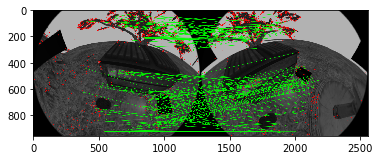

(<matplotlib.image.AxesImage at 0x7f12065e8280>, None)

In [11]:
matches = flann.knnMatch(des5,des0,k=2)
# # Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
# ratio test as per Lowe's paper
good_matches = []
for i,(m,n) in enumerate(matches):
    if m.distance < 0.6*n.distance:
        matchesMask[i]=[1,0]
        good_matches.append(m)
 
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)
img3 = cv2.drawMatchesKnn(img5,kp5,img0,kp0,matches,None,**draw_params)
plt.imshow(img3,),plt.show()

In [143]:
for i in undistorted_kp_query:
    cv2.circle(img0_u, tuple(i), 5, (200,0,0),2)

In [144]:
cv2.imshow('kp', img0_u) 
cv2.waitKey(0) 
cv2.destroyAllWindows() 